# Modelação de time series - SARIMA

## Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Leitura

In [8]:
braga_time_series = pd.read_csv('../model/datasets/FINALDATASET.csv')

# merge date and time columns into a datetime column
braga_time_series['datetime'] = pd.to_datetime(braga_time_series['date'] + ' ' + braga_time_series['time'])
braga_time_series.set_index('datetime', inplace=True)

# drop the time column
braga_time_series.drop('time', axis=1, inplace=True)
braga_time_series.head()

,longitude,latitude,no2,pm10,pm25,pm1,date,tempmax,tempmin,temp,...,precip,snow,windspeed,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,AQI
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-8.296389,41.449722,32.9,15.0,NaN,NaN,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,33.0
2020-01-01 01:00:00,-8.296389,41.449722,34.1,15.0,NaN,NaN,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,34.0
2020-01-01 02:00:00,-8.296389,41.449722,45.2,15.0,NaN,NaN,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,45.0
2020-01-01 03:00:00,-8.296389,41.449722,44.3,NaN,NaN,NaN,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,44.0
2020-01-01 04:00:00,-8.296389,41.449722,34.1,NaN,NaN,NaN,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,34.0


In [9]:
# replace missing values with the median
missing_columns = ['pm10', 'pm25', 'pm1', 'no2']

for column in missing_columns:
    braga_time_series[column] = braga_time_series[column].fillna(braga_time_series[column].median())

braga_time_series.head()

,longitude,latitude,no2,pm10,pm25,pm1,date,tempmax,tempmin,temp,...,precip,snow,windspeed,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,AQI
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-8.296389,41.449722,32.9,15.0,4.3,4.78,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,33.0
2020-01-01 01:00:00,-8.296389,41.449722,34.1,15.0,4.3,4.78,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,34.0
2020-01-01 02:00:00,-8.296389,41.449722,45.2,15.0,4.3,4.78,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,45.0
2020-01-01 03:00:00,-8.296389,41.449722,44.3,15.0,4.3,4.78,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,44.0
2020-01-01 04:00:00,-8.296389,41.449722,34.1,15.0,4.3,4.78,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,34.0


## Modelação

In [ ]:
# divide the dataset into training and testing sets
train = braga_time_series[:'2019-12-31']
test = braga_time_series['2020-01-01':]

# plot the training and testing sets
plt.figure(figsize=(12, 6))
plt.plot(train['pm10'], label='Training set')
plt.plot(test['pm10'], label='Testing set')
plt.legend()

### SARIMA

### Determine the order of differencing (d), which helps make the time series stationary. Stationarity is an assumption of ARIMA models. You can use techniques like the Augmented Dickey-Fuller (ADF) test to check for stationarity. If the p-value is greater than a significance level (e.g., 0.05), it indicates that the series is not stationary and differencing is required. Repeat this step until the series becomes stationary.

In [10]:
result = adfuller(braga_time_series['AQI'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.798380586220405
p-value: 4.6934135928035885e-07


Based on the results you provided, the ADF (Augmented Dickey-Fuller) test statistic is -5.798380586220405 and the corresponding p-value is 4.6934135928035885e-07, which is significantly smaller than the typical significance level of 0.05.

Since the p-value is below the significance level, it suggests that you can reject the null hypothesis of non-stationarity. In other words, the time series data (braga_time_series['AQI']) appears to be stationary. Therefore, there is no need for further differencing in this case.

With a stationary time series, you can proceed with determining the appropriate parameters (p and q) for the autoregressive (AR) and moving average (MA) components of the ARIMA model, respectively, and fit the model.

Please note that while the ADF test indicates stationarity in this case, it's still important to inspect other diagnostic plots and evaluate the model's performance to ensure its adequacy for forecasting or further analysis.

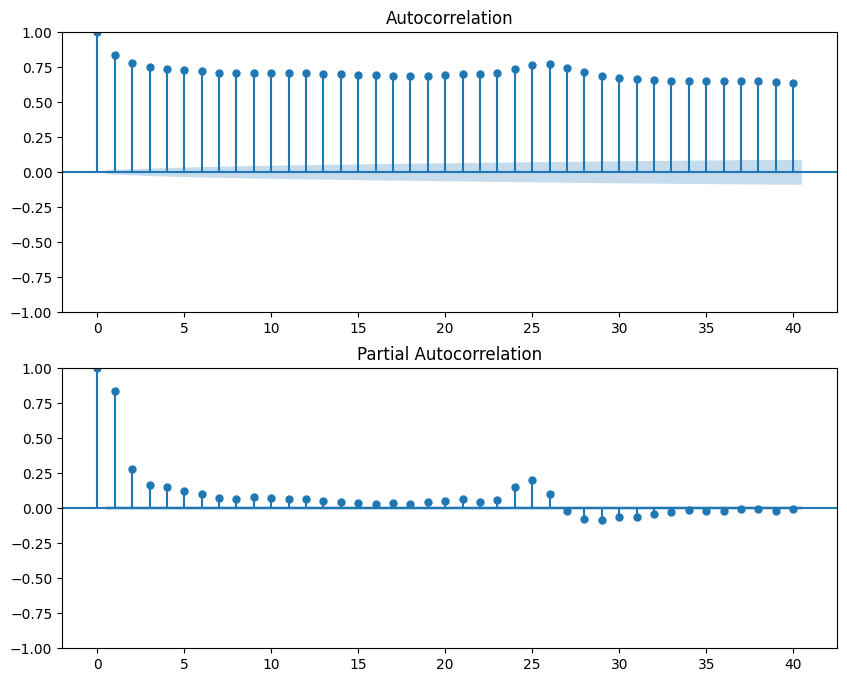

In [11]:


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(braga_time_series['AQI'], ax=ax1, lags=40)
plot_pacf(braga_time_series['AQI'], ax=ax2, lags=40)
plt.show()


In [12]:
p = 0 # we can see that the PACF is 0 after lag 1
d = 0 # its already stationary
q = 25 # we can see that the ACF is 0 after lag 26
model = ARIMA(braga_time_series['AQI'], order=(p, d, q))
model_fit = model.fit()


                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                19198
Model:                ARIMA(0, 0, 25)   Log Likelihood             -104380.891
Date:                Thu, 25 May 2023   AIC                         208815.782
Time:                        22:00:19   BIC                         209028.071
Sample:                             0   HQIC                        208885.374
                              - 19198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.2988      5.257     16.988      0.000      78.996      99.602
ma.L1          0.5184      0.005     94.786      0.000       0.508       0.529
ma.L2          0.4426      0.008     58.347      0.0

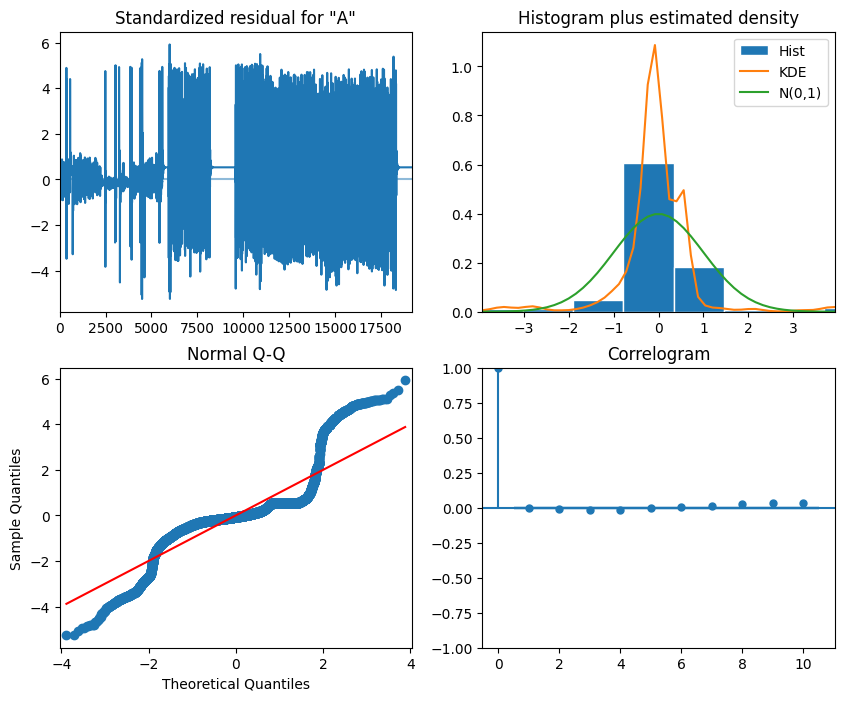

In [13]:
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()


In [18]:
start_date = pd.to_datetime('2020-01-01 00:00:00')
end_date = pd.to_datetime('2022-07-31 00:00:00')
forecast = model_fit.predict(start=start_date, end=end_date)


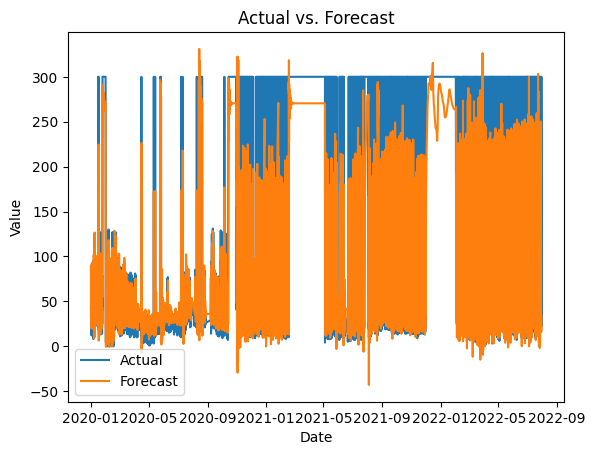

In [19]:
plt.plot(braga_time_series['AQI'], label='Actual')
plt.plot(forecast, label='Forecast')
plt.title('Actual vs. Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [24]:
# print the forecast
forecast

datetime
2020-01-01 00:00:00    89.298841
2020-01-01 01:00:00    43.627589
2020-01-01 02:00:00    41.417011
2020-01-01 03:00:00    46.768271
2020-01-01 04:00:00    47.564017
                         ...    
2022-07-30 17:00:00    16.592975
2022-07-30 18:00:00    24.915966
2022-07-30 19:00:00    27.957432
2022-07-30 20:00:00    23.624689
2022-07-31 00:00:00    33.911478
Name: predicted_mean, Length: 18321, dtype: float64

In [27]:
# make predictions for the next 7 days
start_date = pd.to_datetime('2021-07-31 00:00:00')
end_date = pd.to_datetime('2021-08-07 00:00:00')
forecast = model_fit.predict(start=start_date, end=end_date)
print(forecast)

datetime
2021-07-31 00:00:00    266.010547
2021-08-01 00:00:00    278.900610
2021-08-02 00:00:00    279.150387
2021-08-03 00:00:00    274.069546
2021-08-03 16:00:00    280.246881
2021-08-03 17:00:00    142.181789
2021-08-03 18:00:00     99.203091
2021-08-03 19:00:00     79.784818
2021-08-03 20:00:00     64.761677
2021-08-03 21:00:00     44.190224
2021-08-03 22:00:00     26.822368
2021-08-03 23:00:00     38.522163
2021-08-04 00:00:00     60.876657
2021-08-04 00:00:00    166.924379
2021-08-04 01:00:00     47.413906
2021-08-04 02:00:00      6.430309
2021-08-04 03:00:00     -4.035083
2021-08-04 04:00:00    -27.418467
2021-08-04 05:00:00    -43.066469
2021-08-04 06:00:00    -32.592311
2021-08-04 07:00:00     11.702008
2021-08-04 08:00:00     31.188696
2021-08-04 09:00:00     47.129734
2021-08-04 10:00:00     55.214024
2021-08-04 11:00:00     61.770331
2021-08-04 12:00:00     59.564158
2021-08-05 00:00:00     66.669846
2021-08-05 23:00:00    220.525109
2021-08-06 00:00:00    106.774898
2021-